In [ ]:
# %%
# Cell 1: Imports
!pip install pandas numpy matplotlib seaborn ipywidgets scikit-learn xgboost joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, r2_score,
    confusion_matrix, classification_report, mean_squared_error
)
from xgboost import XGBClassifier, XGBRegressor
import joblib


: 

In [2]:
# %%
# Cell 2: Load data & define features/targets
df = pd.read_csv('data_csv_1.csv')

numerical_features = [
    '10th_percent','12th_percent','jee_rank','experience','experience_field',
    'num_projects','expertise_level','num_internships','soft_skill_rating',
    'aptitude_rating','dsa_level','num_hackathons','competitive_coding_solved',
    'num_repos','github_activities','linkedin_posts','num_certifications','cgpa'
]
categorical_features = ['gender','domain','referral']

target_col_college = 'college_tier'
target_col_name    = 'college_name'
target_col_branch  = 'branch'
target_col_salary  = 'salary'

df = df[
    numerical_features +
    categorical_features +
    [target_col_college, target_col_name, target_col_branch, target_col_salary]
]
print("Data loaded. Shape:", df.shape)


Data loaded. Shape: (5000, 25)


KeyboardInterrupt: 

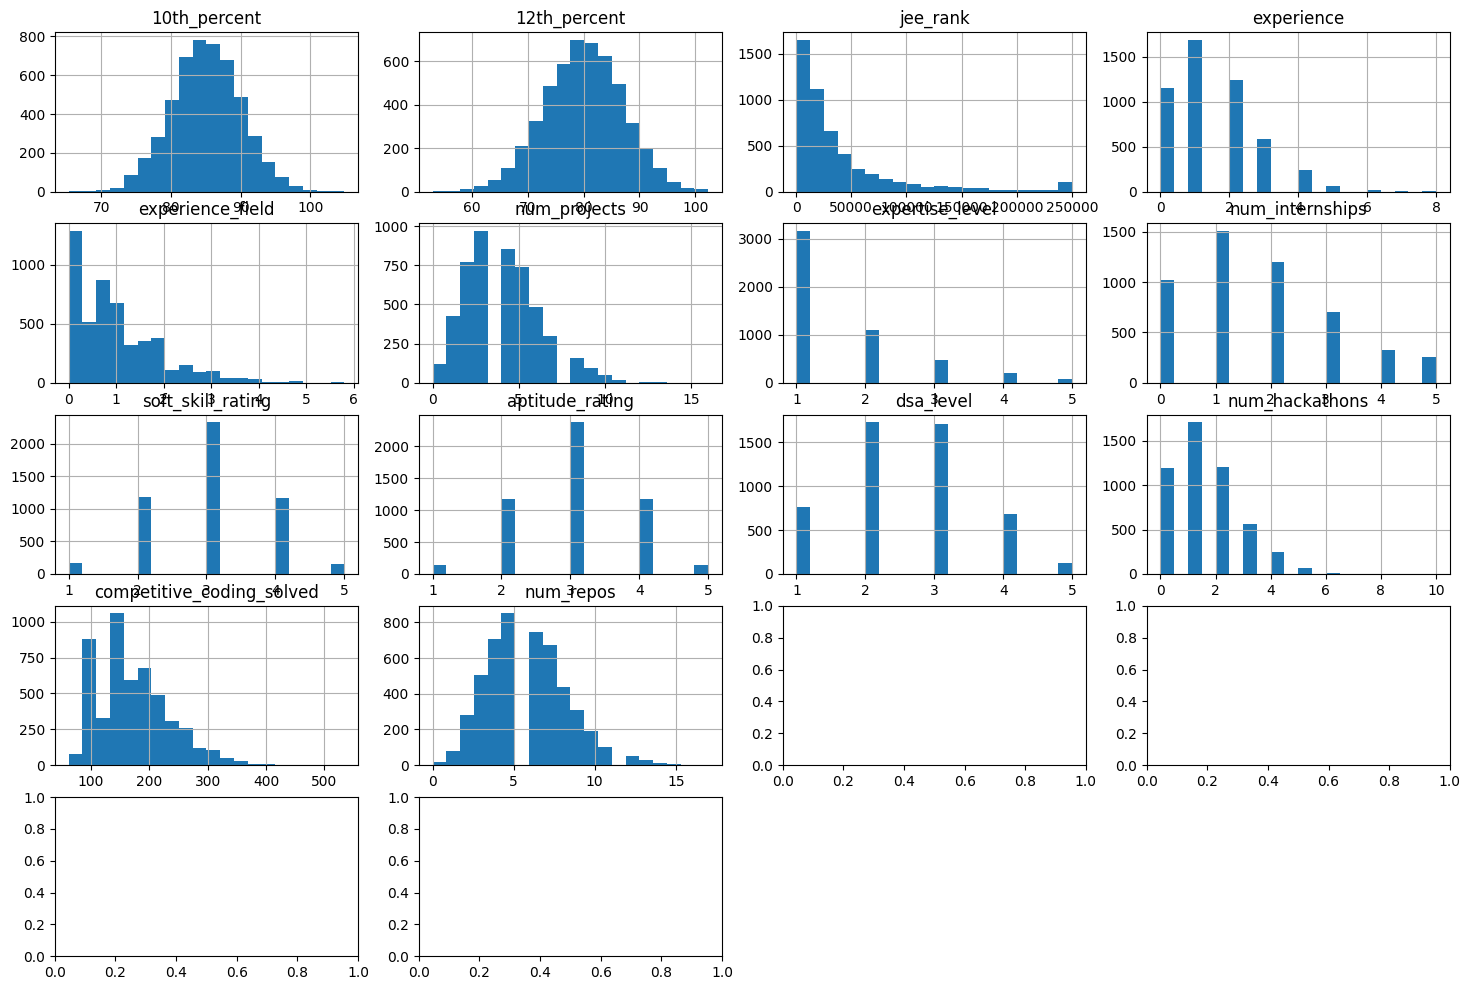

In [3]:
# %%
# Cell 3: Quick EDA (optional)
df[numerical_features].hist(figsize=(18,12), bins=20)
plt.suptitle("Numerical Features")
plt.show()

for col in categorical_features + [target_col_college, target_col_name, target_col_branch]:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, palette="viridis")
    plt.title(f"Count Plot: {col}")
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Cell 4: Corrected Encoding
# 4.1 Tier - Use actual tier names from data generation
college_hierarchy = [
    'Tier 4 - Other',
    'Tier 3 - Private/State', 
    'Tier 2 - Mid Colleges',
    'Tier 1 - Other IIT/Top NIT',
    'Tier 1 - Top IIT'
]

college_encoder = OrdinalEncoder(categories=[college_hierarchy])
df['college_tier_encoded'] = college_encoder.fit_transform(df[[target_col_college]])

# 4.2 Name & branch - Use automatic category discovery
name_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df['college_name_encoded'] = name_encoder.fit_transform(df[[target_col_name]])

branch_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df['branch_encoded'] = branch_encoder.fit_transform(df[[target_col_branch]])

# 4.3 Split (keep the rest same)
X = df[numerical_features + categorical_features]
y_tier = df['college_tier_encoded']
y_name = df['college_name_encoded']
y_branch = df['branch_encoded']
y_salary = df[target_col_salary]

X_train, X_test, yt_train, yt_test, yn_train, yn_test, yb_train, yb_test, ys_train, ys_test = train_test_split(
    X, y_tier, y_name, y_branch, y_salary,
    test_size=0.2, random_state=42
)

In [ ]:
# %%
# Cell 5: Preprocessor, Pipelines & Grids
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Classification pipelines
clf_kwargs = dict(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, random_state=42)
college_pipeline = Pipeline([('pre', preprocessor), ('model', XGBClassifier(**clf_kwargs))])
name_pipeline    = Pipeline([('pre', preprocessor), ('model', XGBClassifier(**clf_kwargs))])
branch_pipeline  = Pipeline([('pre', preprocessor), ('model', XGBClassifier(**clf_kwargs))])

# Regression pipeline
salary_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter grids
college_params = {
    'model__n_estimators': [500, 1000],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [5, 7]
}
name_params   = college_params
branch_params = college_params
salary_params = {
    'model__n_estimators': [800, 1200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}


In [ ]:
# %%
# Cell 6: Train models
# 6.1 College Tier
print("Training College Tier...")
tier_grid = GridSearchCV(college_pipeline, college_params, cv=5, scoring='accuracy', n_jobs=-1)
tier_grid.fit(X_train, yt_train)
best_tier_model = tier_grid.best_estimator_
print("→ Tier best params:", tier_grid.best_params_)

# 6.2 College Name
print("Training College Name...")
name_grid = GridSearchCV(name_pipeline, name_params, cv=5, scoring='accuracy', n_jobs=-1)
name_grid.fit(X_train, yn_train)
best_name_model = name_grid.best_estimator_
print("→ Name best params:", name_grid.best_params_)

# 6.3 Branch
# 6.3 Branch
print("Training Branch...")

# Check class balance
from sklearn.utils.class_weight import compute_class_weight
branch_classes = np.unique(yb_train)
class_weights = compute_class_weight('balanced', classes=branch_classes, y=yb_train)
branch_weight_dict = dict(zip(branch_classes, class_weights))

# Modify XGBClassifier with scale_pos_weight logic manually (for multi-class)
sample_weights = yb_train.map(branch_weight_dict)

# Updated grid with slightly more flexible params
branch_params = {
    'model__n_estimators': [300, 500],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [5, 7, 9],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

branch_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

branch_grid = GridSearchCV(
    branch_pipeline,
    branch_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

branch_grid.fit(X_train, yb_train, model__sample_weight=sample_weights)
best_branch_model = branch_grid.best_estimator_
print("→ Branch best params:", branch_grid.best_params_)


# 6.4 Salary
print("Training Salary...")
salary_grid = GridSearchCV(salary_pipeline, salary_params, cv=5, scoring='r2', n_jobs=-1)
salary_grid.fit(X_train, ys_train)
best_salary_model = salary_grid.best_estimator_
print("→ Salary best params:", salary_grid.best_params_)


In [ ]:
# %%
# Cell 7: Evaluate models
def evaluate_models():
    # Tier
    p_t = best_tier_model.predict(X_test)
    print(f"Tier Acc: {accuracy_score(yt_test,p_t):.2%}")
    print(classification_report(yt_test,p_t,target_names=college_hierarchy))
    cm = confusion_matrix(yt_test,p_t)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=college_hierarchy, yticklabels=college_hierarchy)
    plt.title("Tier CM"); plt.show()

    # Name
    p_n = best_name_model.predict(X_test)
    names = name_encoder.categories_[0]
    print(f"Name Acc: {accuracy_score(yn_test,p_n):.2%}")
    print(classification_report(yn_test,p_n,target_names=names))
    cm = confusion_matrix(yn_test,p_n)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=names, yticklabels=names)
    plt.title("Name CM"); plt.show()

    # Branch
    p_b = best_branch_model.predict(X_test)
    branches = branch_encoder.categories_[0]
    print(f"Branch Acc: {accuracy_score(yb_test,p_b):.2%}")
    print(classification_report(yb_test,p_b,target_names=branches))
    cm = confusion_matrix(yb_test,p_b)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=branches, yticklabels=branches)
    plt.title("Branch CM"); plt.show()

    # Salary
    p_s = best_salary_model.predict(X_test)
    print(f"Salary MAE: ₹{mean_absolute_error(ys_test,p_s):,.0f}")
    print(f"Salary RMSE: ₹{np.sqrt(mean_squared_error(ys_test,p_s)):,.0f}")
    print(f"Salary R²: {r2_score(ys_test,p_s):.2%}")
    plt.scatter(ys_test,p_s,alpha=0.3)
    plt.plot([ys_test.min(),ys_test.max()],[ys_test.min(),ys_test.max()],'r--')
    plt.title("Actual vs Predicted Salary"); plt.show()

# run evaluation
evaluate_models()


In [ ]:
# %%
# Cell 8: Interactive Prediction Interface
def predict_admission_interactive():
    # Widgets with correct argument syntax
    tenth   = widgets.FloatText(value=80.0, description='10th %:')
    twelfth = widgets.FloatText(value=80.0, description='12th %:')
    jee     = widgets.IntText(value=1000,  description='JEE Rank:')
    workexp = widgets.IntText(value=2,     description='Work Exp:')
    fexp    = widgets.IntSlider(value=2, min=0, max=20, step=1, description='Field Exp:')
    proj    = widgets.IntSlider(value=1, min=0, max=20, step=1, description='Projects:')
    exp_lev = widgets.Dropdown(options=[1,2,3,4,5], value=3, description='Expertise:')
    intern  = widgets.IntSlider(value=0, min=0, max=10, step=1, description='Internships:')
    soft    = widgets.Dropdown(options=[1,2,3,4,5], value=3, description='Soft Skills:')
    apt     = widgets.Dropdown(options=[1,2,3,4,5], value=3, description='Aptitude:')
    dsa     = widgets.Dropdown(options=[1,2,3,4,5], value=3, description='DSA Level:')
    hack    = widgets.IntSlider(value=0, min=0, max=10, step=1, description='Hackathons:')
    codeqs  = widgets.IntSlider(value=50, min=0, max=200, step=10, description='Coding Qs:')
    repos   = widgets.IntSlider(value=5, min=0, max=50, step=1, description='Repos:')
    ghacts  = widgets.IntSlider(value=10, min=0, max=50, step=1, description='GitHub Acts:')
    li      = widgets.IntSlider(value=3, min=0, max=50, step=1, description='LinkedIn Posts:')
    certs   = widgets.IntSlider(value=0, min=0, max=20, step=1, description='Certifications:')
    cgpa    = widgets.FloatSlider(value=7.0, min=1, max=10, step=0.1, description='CGPA:')
    gender  = widgets.Dropdown(options=['Male','Female','Other'], value='Male', description='Gender:')
    domain  = widgets.Dropdown(options=['Full Stack','Machine Learning','Android Development','Other'], value='Full Stack', description='Domain:')
    ref     = widgets.Dropdown(options=['Yes','No'], value='No', description='Referral:')
    btn     = widgets.Button(description="Predict")
    out     = widgets.Output()

    def on_click(b):
        with out:
            clear_output()
            ui = {
                '10th_percent': tenth.value,
                '12th_percent': twelfth.value,
                'jee_rank': jee.value,
                'experience': workexp.value,
                'experience_field': fexp.value,
                'num_projects': proj.value,
                'expertise_level': exp_lev.value,
                'num_internships': intern.value,
                'soft_skill_rating': soft.value,
                'aptitude_rating': apt.value,
                'dsa_level': dsa.value,
                'num_hackathons': hack.value,
                'competitive_coding_solved': codeqs.value,
                'num_repos': repos.value,
                'github_activities': ghacts.value,
                'linkedin_posts': li.value,
                'num_certifications': certs.value,
                'cgpa': cgpa.value,
                'gender': gender.value,
                'domain': domain.value,
                'referral': ref.value
            }
            inp = pd.DataFrame([ui])
            t_code = best_tier_model.predict(inp)[0]
            n_code = best_name_model.predict(inp)[0]
            b_code = best_branch_model.predict(inp)[0]
            sal    = best_salary_model.predict(inp)[0]
            print(f"Tier   : {college_hierarchy[int(t_code)]}")
            print(f"Name   : {name_encoder.inverse_transform([[n_code]])[0][0]}")
            print(f"Branch : {branch_encoder.inverse_transform([[b_code]])[0][0]}")
            print(f"Salary : ₹{sal:,.2f}")

    btn.on_click(on_click)

    ui = widgets.VBox([
        widgets.HBox([tenth, twelfth, jee]),
        widgets.HBox([workexp, fexp]),
        widgets.HBox([proj, exp_lev, intern]),
        widgets.HBox([soft, apt, dsa]),
        widgets.HBox([hack, codeqs]),
        widgets.HBox([repos, ghacts, li]),
        widgets.HBox([certs, cgpa]),
        widgets.HBox([gender, domain, ref]),
        btn, out
    ])
    display(ui)

predict_admission_interactive()


In [ ]:
# %% 
# Cell 9: Save trained models to .pkl files for deployment

# import joblib

# Save each model
joblib.dump(best_tier_model,   'tier_model.pkl')
joblib.dump(best_name_model,   'name_model.pkl')
joblib.dump(best_branch_model, 'branch_model.pkl')
joblib.dump(best_salary_model, 'salary_model.pkl')

# Save the encoders
joblib.dump(name_encoder,   'name_encoder.pkl')
joblib.dump(branch_encoder, 'branch_encoder.pkl')
joblib.dump(college_encoder, 'college_encoder.pkl')

# Save the column transformer
joblib.dump(preprocessor, 'preprocessor.pkl')

print("All models, encoders, and preprocessor saved successfully.")
